Here we synthesize Gaussian non-linear dimensionality reduction models across conditions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import Identity

from janelia_core.math.basic_functions import optimal_orthonormal_transform
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.extra_torch_modules import PWLNNFcn
from janelia_core.ml.extra_torch_modules import QuadSurf
from janelia_core.ml.utils import list_torch_devices
from janelia_core.ml.utils import torch_mod_to_fcn
from janelia_core.visualization.image_generation import generate_2d_fcn_image
from janelia_core.visualization.matrix_visualization import cmp_n_mats

from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import align_intermediate_spaces
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import compare_mean_and_lm_dists
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import GNLDRMdl
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_basic_posteriors
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_hypercube_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_simple_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import VICollection
from probabilistic_model_synthesis.math import MeanFcnTransformer
from probabilistic_model_synthesis.math import StdFcnTransformer
from probabilistic_model_synthesis.visualization import assign_colors_to_pts
from probabilistic_model_synthesis.visualization import plot_three_dim_pts
from probabilistic_model_synthesis.visualization import plot_torch_dist

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
# Number of individuals we simulate observing data from 
n_individuals = 5

# Range of the number of variables we observe from each individual - the actual number of variables we observe from an
# individual will be pulled uniformly from this range (inclusive)
n_var_range = [100, 120]

# Range of the numbe0 of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [10000, 15000]

# Number of latent variables in the model
n_latent_vars = 2

# True if we should use GPUs for fitting if they are available
use_gpus = True

# Parameters for the true scales
s_mn = 1.0
s_std = .0001

# Parameters for generating shared m-module we use for fitting
m_n_layers = 2 #2
m_growth_rate = 2 #2
n_intermediate_latent_vars = 3 #3

In [5]:
## Determine which devices we use for fitting

In [6]:
if use_gpus:
    devices, _ = list_torch_devices()
else:
    devices = [torch.device('cpu')]

Found 1 GPUs


## Create the true prior distributions that relate parameters in the model to variable (e.g., neuron) properties

In [7]:
m_true = QuadSurf(torch.tensor([.5, .5]), torch.tensor([.2, -.2]))

In [8]:
true_priors = generate_hypercube_prior_collection(n_intermediate_latent_vars=n_intermediate_latent_vars,
                                                  hc_params = {'n_divisions_per_dim': [10, 10], 
                                                               'dim_ranges': np.asarray([[-.1, 1.1], 
                                                                                         [-.1, 1.1]]),
                                                               'n_div_per_hc_side_per_dim': [1, 1]},
                                                  psi_rate_vl_init=10,
                                               s_mn=s_mn, s_std=s_std)

for d in range(n_intermediate_latent_vars):
    true_priors.lm_prior.dists[d].mn_f.b_m.data[:] = torch.randn(true_priors.lm_prior.dists[d].mn_f.b_m.data.shape)
    true_priors.mn_prior.mn_f.b_m.data[:] = 1*torch.randn(true_priors.mn_prior.mn_f.b_m.data.shape)

## Generate properties

In [9]:
ind_n_vars = np.random.randint(n_var_range[0], n_var_range[1]+1, n_individuals)
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

## Generate true models

In [10]:
with torch.no_grad():
    ind_true_mdls = [GNLDRMdl(n_latent_vars=n_latent_vars, m = m_true,
                              lm=true_priors.lm_prior.form_standard_sample(true_priors.lm_prior.sample(props)), 
                              mn=true_priors.mn_prior.sample(props).squeeze(), 
                              psi=(true_priors.psi_prior.sample(props).squeeze()), 
                              s=true_priors.s_prior.sample(props).squeeze())
                        for props in ind_props]

## Generate data from each model

In [11]:
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)
with torch.no_grad():
    ind_data = [mdl.sample(n_smps) for n_smps, mdl in zip(ind_n_smps, ind_true_mdls)]
    
# Now pair down the data for each model so that data from differents part of the latent space are observed in 
# each model

ind_ang_range = 360/n_individuals
for i in range(n_individuals):
    cur_start_ang = i*ind_ang_range
    cur_end_ang = (i+1)*ind_ang_range
    
    angles = np.asarray([math.degrees(math.atan2(p[0], p[1])) for p in ind_data[i][0]]) + 180
    keep_pts = np.logical_and(angles > cur_start_ang, angles < cur_end_ang)  
    
    ind_data[i] = (ind_data[i][0][keep_pts, :], ind_data[i][1][keep_pts, :])

# Update number of samples we actually have for each subject
ind_n_smps = [data[0].shape[0] for data in ind_data]

## Setup everything for fitting sp models

In [12]:
sp_m_fit = torch.nn.Sequential(DenseLNLNet(nl_class=torch.nn.ReLU, 
                                         d_in=n_latent_vars, 
                                         n_layers=m_n_layers, 
                                         growth_rate=m_growth_rate, 
                                         bias=True), 
                             torch.nn.Linear(in_features=n_latent_vars+m_n_layers*m_growth_rate, 
                                             out_features=n_intermediate_latent_vars, 
                                             bias=True))


In [13]:
sp_priors = generate_hypercube_prior_collection(n_intermediate_latent_vars=n_intermediate_latent_vars,
                                                  hc_params = {'n_divisions_per_dim': [10, 10], 
                                                               'dim_ranges': np.asarray([[-.1, 1.1], 
                                                                                         [-.1, 1.1]]),
                                                               'n_div_per_hc_side_per_dim': [1, 1]},
                                               s_mn=s_mn, s_std=s_std)
    
sp_posteriors = generate_basic_posteriors(n_obs_vars=ind_n_vars, n_smps=ind_n_smps, n_latent_vars=n_latent_vars, 
                                          n_intermediate_latent_vars=n_intermediate_latent_vars,
                                           s_opts={'mn_mn': 1.0, 'mn_std': .00000001, 'std_iv': .0001})

sp_fit_mdls = [GNLDRMdl(n_latent_vars=n_latent_vars, m=sp_m_fit, lm=None, mn=None, psi=None, s=None) 
               for i in range(n_individuals)]
                    
                                    
sp_vi_collections = [VICollection(data=ind_data[s_i][1], 
                                  props=ind_props[s_i],
                                  mdl = sp_fit_mdls[s_i],
                                  posteriors = sp_posteriors[s_i]) for s_i in range(n_individuals)]

for vi_coll in sp_vi_collections:
    vi_coll.posteriors.lm_post = sp_priors.lm_prior
    vi_coll.posteriors.mn_post = sp_priors.mn_prior

## Fit the sp models

In [14]:
sp_fitter = Fitter(vi_collections=sp_vi_collections, priors=sp_priors, devices=devices)

In [15]:
sp_fitter.distribute(distribute_data=True, devices=devices)
sp_logs = [sp_fitter.fit(1000, milestones=[100], update_int=100, init_lr=.1) for fit_r in range(1)]
sp_fitter.distribute(devices=[torch.device('cpu')])


=========== EPOCH 0 COMPLETE ===========
Obj: 1.39e+08
----------------------------------------
NELL: 7.35e+05, 6.75e+05, 1.26e+06, 7.81e+05, 7.20e+05
Latent KL: 5.47e+01, 4.40e+01, 6.43e+01, 4.50e+01, 5.19e+01
LM KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 2.83e+01, 2.97e+01, 2.92e+01, 3.06e+01, 2.79e+01
S KL: 2.65e+07, 2.75e+07, 2.68e+07, 2.80e+07, 2.58e+07
----------------------------------------
LR: 0.1
Elapsed time (secs): 1.1721868515014648
----------------------------------------
CPU cur memory used (GB): 3.00e+00
GPU_0 cur memory used (GB): 5.41e-03, max memory used (GB): 5.41e-03

=========== EPOCH 100 COMPLETE ===========
Obj: 2.00e+06
----------------------------------------
NELL: 4.00e+05, 3.36e+05, 4.81e+05, 3.50e+05, 3.72e+05
Latent KL: 1.21e+04, 9.63e+03, 1.40e+04, 1.03e+04, 1.11e+04
LM KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Psi 

## Examine logs of sp fitting performance

<IPython.core.display.Javascript object>


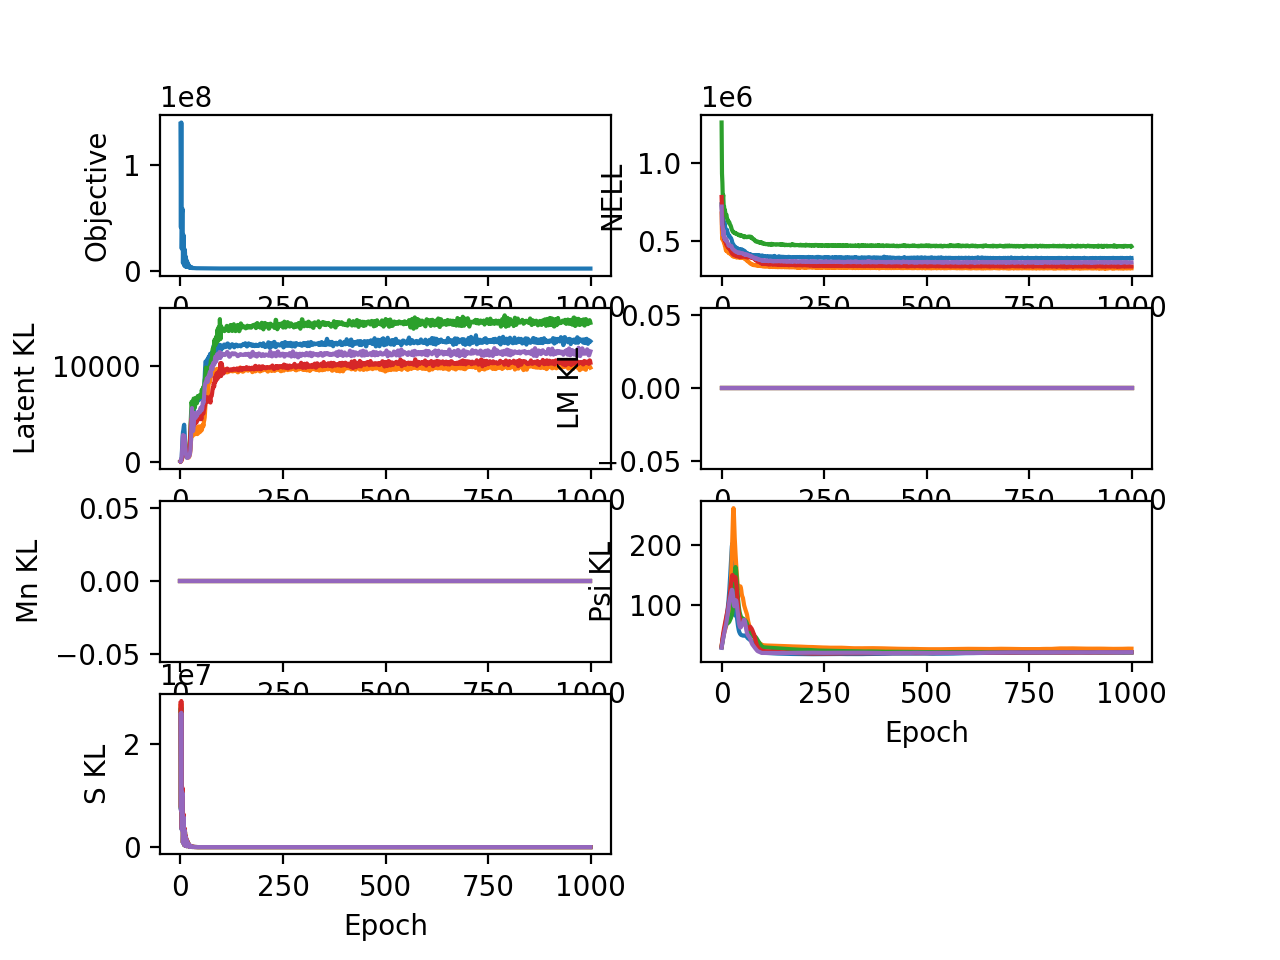

In [16]:
for log in sp_logs:
    sp_fitter.plot_log(log)

## Look at sp model fits

In [17]:
exam_mdl = 0

<IPython.core.display.Javascript object>


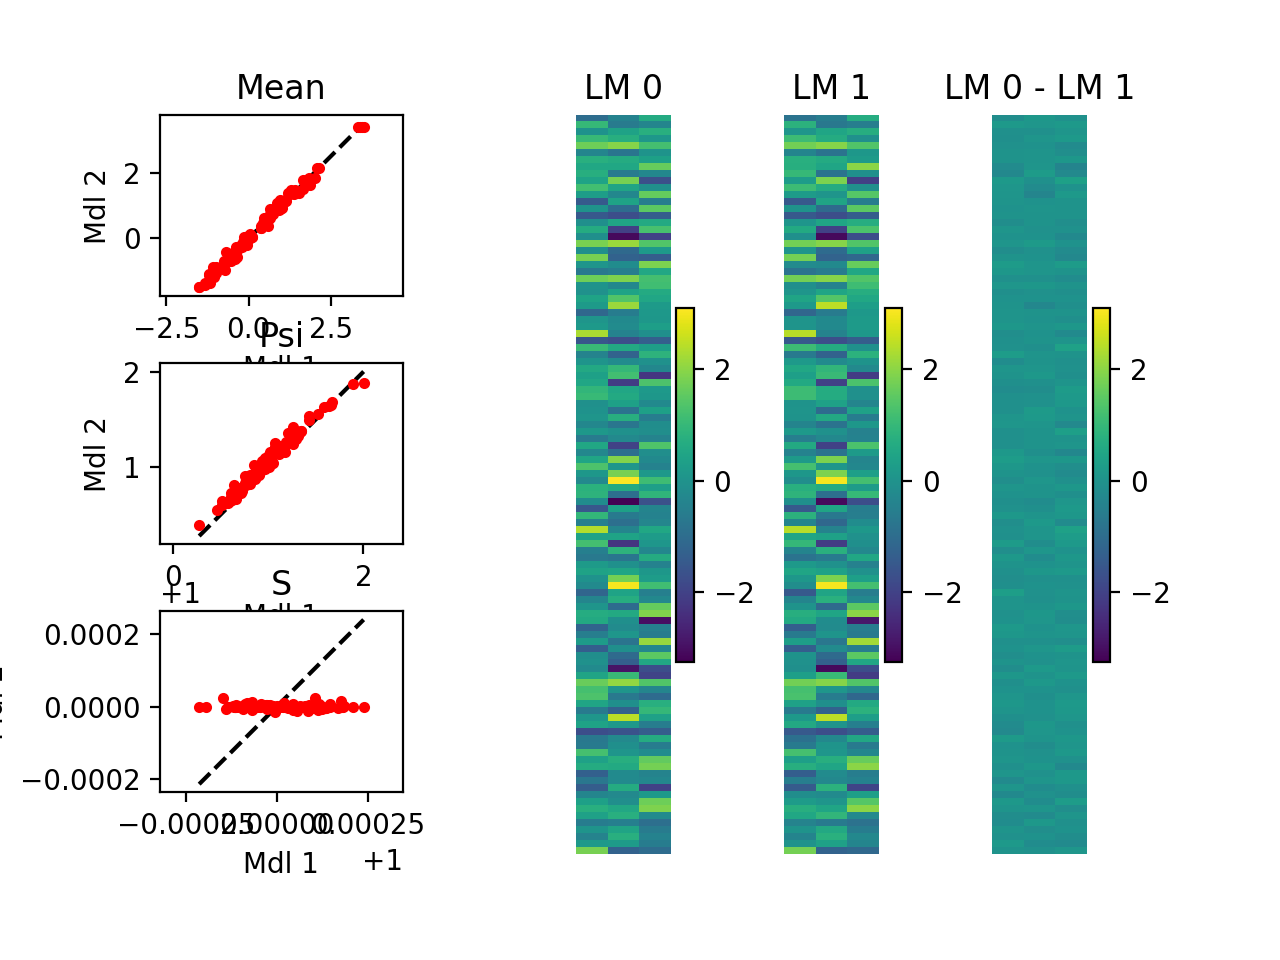

In [18]:
fit_lm = sp_vi_collections[exam_mdl].posteriors.lm_post(ind_props[exam_mdl]).detach().squeeze()
fit_mn = sp_vi_collections[exam_mdl].posteriors.mn_post(ind_props[exam_mdl]).detach().squeeze()
fit_psi = sp_vi_collections[exam_mdl].posteriors.psi_post.mode(ind_props[exam_mdl]).detach().squeeze()
fit_s = sp_vi_collections[exam_mdl].posteriors.s_post(ind_props[exam_mdl]).detach().squeeze()

cmp_mdl = GNLDRMdl(n_latent_vars=n_latent_vars, 
                   m=sp_m_fit, lm=fit_lm, mn=fit_mn, psi=fit_psi, s=fit_s)
true_mdl = ind_true_mdls[exam_mdl]

plt.figure()
true_mdl.compare_models(true_mdl, cmp_mdl)

## Setup everything for fitting models with individual posteriors

In [19]:
ip_m_fit = copy.deepcopy(sp_m_fit)

In [20]:
ip_priors = copy.deepcopy(sp_priors)

ip_posteriors = generate_basic_posteriors(n_obs_vars=ind_n_vars, n_smps=ind_n_smps, n_latent_vars=n_latent_vars, 
                                          n_intermediate_latent_vars=n_intermediate_latent_vars,
                                          s_opts={'mn_mn': s_mn, 'mn_std': .00000001, 'std_iv': .01})

In [21]:
for s_i, posteriors in enumerate(ip_posteriors):
    
    # Initialize the poseteriors for the mean vectors
    with torch.no_grad():
        mn_prior_mn = sp_priors.mn_prior(ind_props[s_i]).squeeze()
        mn_prior_std = sp_priors.mn_prior.std_f(ind_props[s_i]).squeeze()
    
        posteriors.mn_post.dists[0].mn_f.f.vl.data = copy.deepcopy(mn_prior_mn)
        posteriors.mn_post.dists[0].std_f.f.set_value(copy.deepcopy(mn_prior_std.numpy()))
        
    # Initialize the posteriors for the loading matrices
    with torch.no_grad():
          
        for d_i in range(n_latent_vars):
            cur_mn = sp_priors.lm_prior.dists[d_i](ind_props[s_i]).squeeze()
            cur_std = sp_priors.lm_prior.dists[d_i].std_f(ind_props[s_i]).squeeze().numpy()
            
            posteriors.lm_post.dists[d_i].mn_f.f.vl.data = copy.deepcopy(cur_mn)
            posteriors.lm_post.dists[d_i].std_f.f.set_value(copy.deepcopy(cur_std))
        
    # Initialize the posteriors for the private variances
    posteriors.psi_post = copy.deepcopy(sp_posteriors[s_i].psi_post)
    
    # Initialize the posteriors for the scales
    #posteriors.s_post = copy.deepcopy(sp_posteriors[s_i].s_post)
    
    # Initialize the posteriors for the latents
    with torch.no_grad():
        posteriors.latent_post = copy.deepcopy(sp_posteriors[s_i].latent_post)

In [22]:
ip_fit_mdls = [GNLDRMdl(n_latent_vars=n_latent_vars, m=ip_m_fit, lm=None, mn=None, psi=None, s=None) 
               for i in range(n_individuals)]
                    
                    
                   
ip_vi_collections = [VICollection(data=ind_data[s_i][1], 
                                  props=ind_props[s_i],
                                  mdl = ip_fit_mdls[s_i],
                                  posteriors = ip_posteriors[s_i]) for s_i in range(n_individuals)]

## Fit ip model

In [23]:
ip_fitter = Fitter(vi_collections=ip_vi_collections, priors=ip_priors, devices=devices)

In [24]:
ip_fitter.distribute(distribute_data=True, devices=devices)
ip_logs = [ip_fitter.fit(1000, milestones=[100, 500], update_int=100, init_lr=.1) for fit_r in range(1)]
ip_fitter.distribute(devices=[torch.device('cpu')])


=========== EPOCH 0 COMPLETE ===========
Obj: 1.40e+08
----------------------------------------
NELL: 4.91e+05, 4.07e+05, 5.52e+05, 3.76e+05, 3.88e+05
Latent KL: 1.29e+04, 1.00e+04, 1.39e+04, 9.47e+03, 1.19e+04
LM KL: 1.27e+05, 1.19e+05, 1.09e+05, 1.36e+05, 1.65e+05
Mn KL: 9.88e+01, 1.08e+02, 9.77e+01, 1.04e+02, 9.91e+01
Psi KL: 2.07e+01, 2.66e+01, 2.09e+01, 2.06e+01, 2.06e+01
S KL: 2.69e+07, 2.80e+07, 2.72e+07, 2.85e+07, 2.62e+07
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.3476223945617676
----------------------------------------
CPU cur memory used (GB): 3.01e+00
GPU_0 cur memory used (GB): 5.51e-03, max memory used (GB): 5.51e-03

=========== EPOCH 100 COMPLETE ===========
Obj: 1.91e+06
----------------------------------------
NELL: 3.83e+05, 3.21e+05, 4.62e+05, 3.33e+05, 3.59e+05
Latent KL: 1.10e+04, 8.00e+03, 1.26e+04, 8.74e+03, 9.10e+03
LM KL: 4.07e+02, 4.03e+02, 4.84e+02, 4.66e+02, 4.22e+02
Mn KL: 3.48e+02, 3.40e+02, 3.70e+02, 3.77e+02, 3.42e+02
Psi 

## Look at aligned ip model fits

In [25]:
exam_mdl = 4

<IPython.core.display.Javascript object>


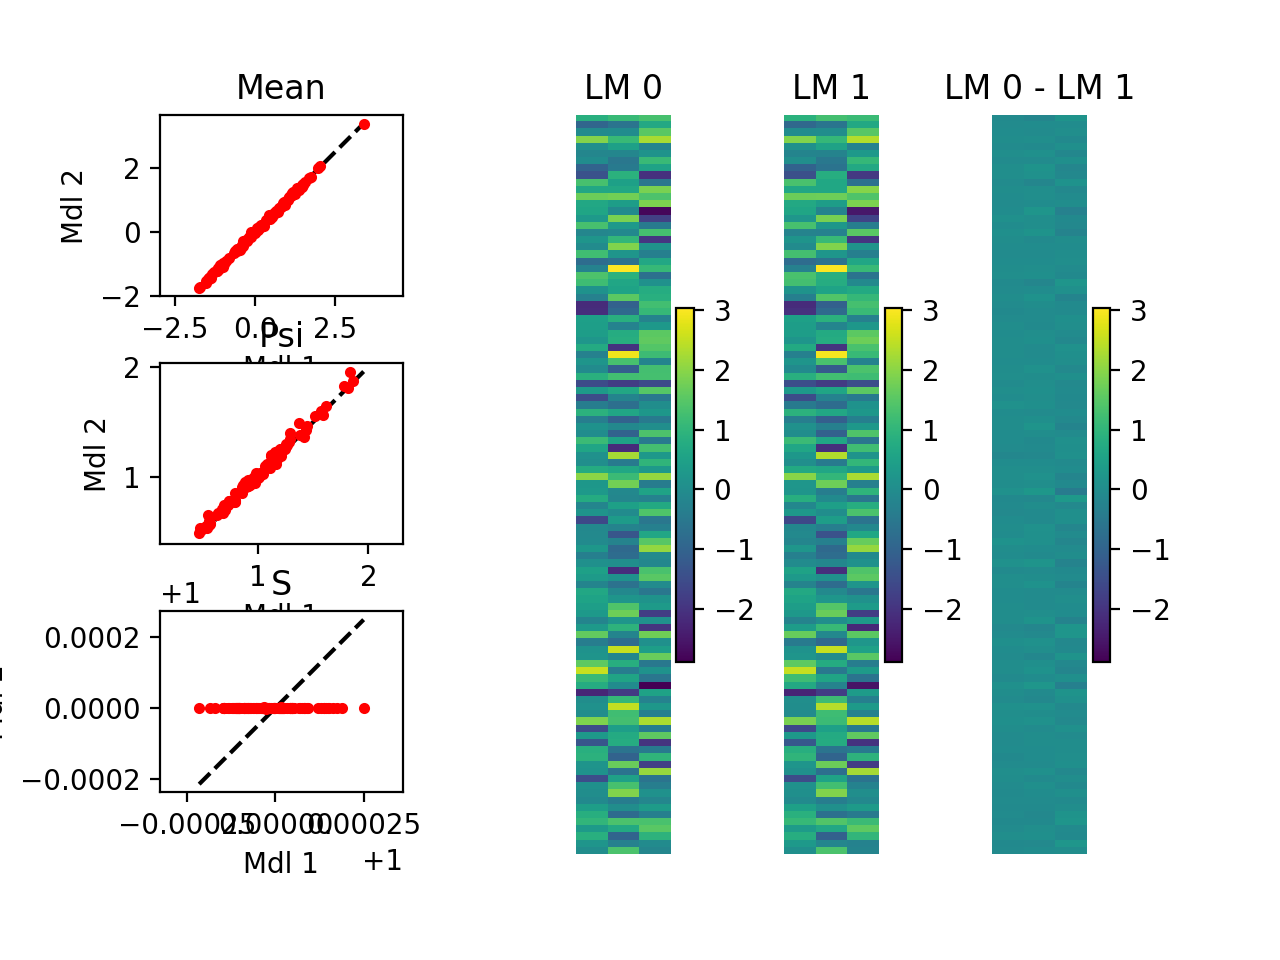

In [26]:
fit_lm = ip_vi_collections[exam_mdl].posteriors.lm_post(ind_props[exam_mdl]).detach().squeeze()
fit_mn = ip_vi_collections[exam_mdl].posteriors.mn_post(ind_props[exam_mdl]).detach().squeeze()
fit_psi = ip_vi_collections[exam_mdl].posteriors.psi_post.mode(ind_props[exam_mdl]).detach().squeeze()
fit_s = ip_vi_collections[exam_mdl].posteriors.s_post(ind_props[exam_mdl]).detach().squeeze()

cmp_mdl = GNLDRMdl(n_latent_vars=n_latent_vars, m=Identity(), lm=fit_lm, mn=fit_mn, psi=fit_psi, s=fit_s)

plt.figure()
true_mdl.compare_models(ind_true_mdls[exam_mdl], cmp_mdl)

## Look at true and estimated intermediate latents

In [27]:
intermediate_z_true = m_true(ind_data[exam_mdl][0]).detach().numpy()
intermediate_z_fit = ip_m_fit(ip_posteriors[exam_mdl].latent_post.mns).detach().numpy()

In [28]:
aligned_mn, aligned_lm, w, aligned_intermediate_z = align_intermediate_spaces(lm0=ind_true_mdls[exam_mdl].lm.detach().numpy(), 
                          mn0=ind_true_mdls[exam_mdl].mn.detach().numpy(),
                          s0=ind_true_mdls[exam_mdl].s.detach().numpy(),
                          lm1=fit_lm.detach().numpy(), 
                          mn1=fit_mn.detach().numpy(),
                          s1=fit_s.detach().numpy(), 
                          int_z0=intermediate_z_true, 
                          int_z1=intermediate_z_fit, 
                          align_by_params=True)

<IPython.core.display.Javascript object>


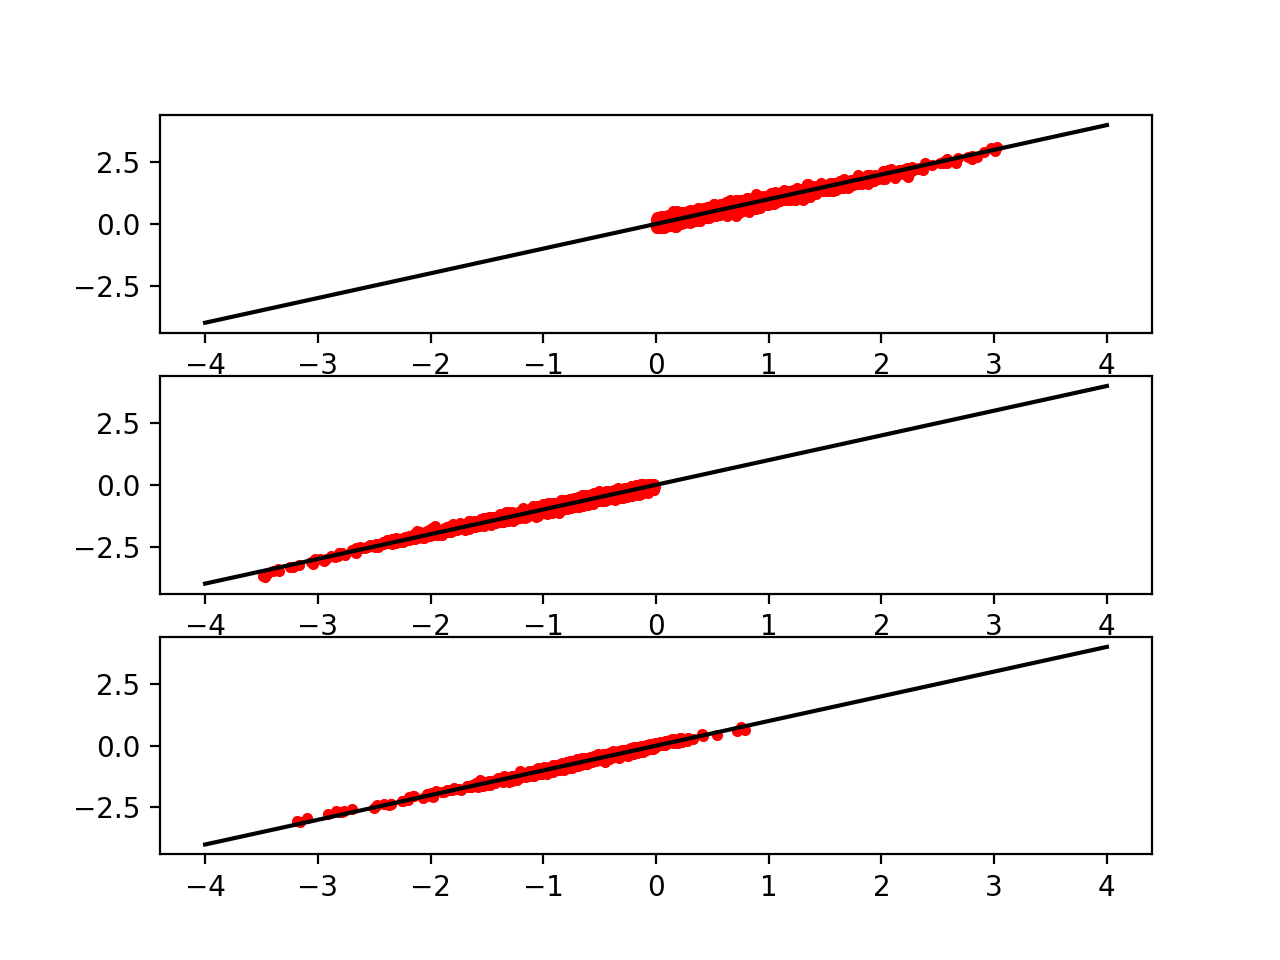

In [29]:
plt.figure()
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(intermediate_z_true[:, i], aligned_intermediate_z[:, i], 'r.')
    plt.plot([-4, 4], [-4, 4], 'k-')

## Look at points from all individuals in the intermediate space 

<IPython.core.display.Javascript object>


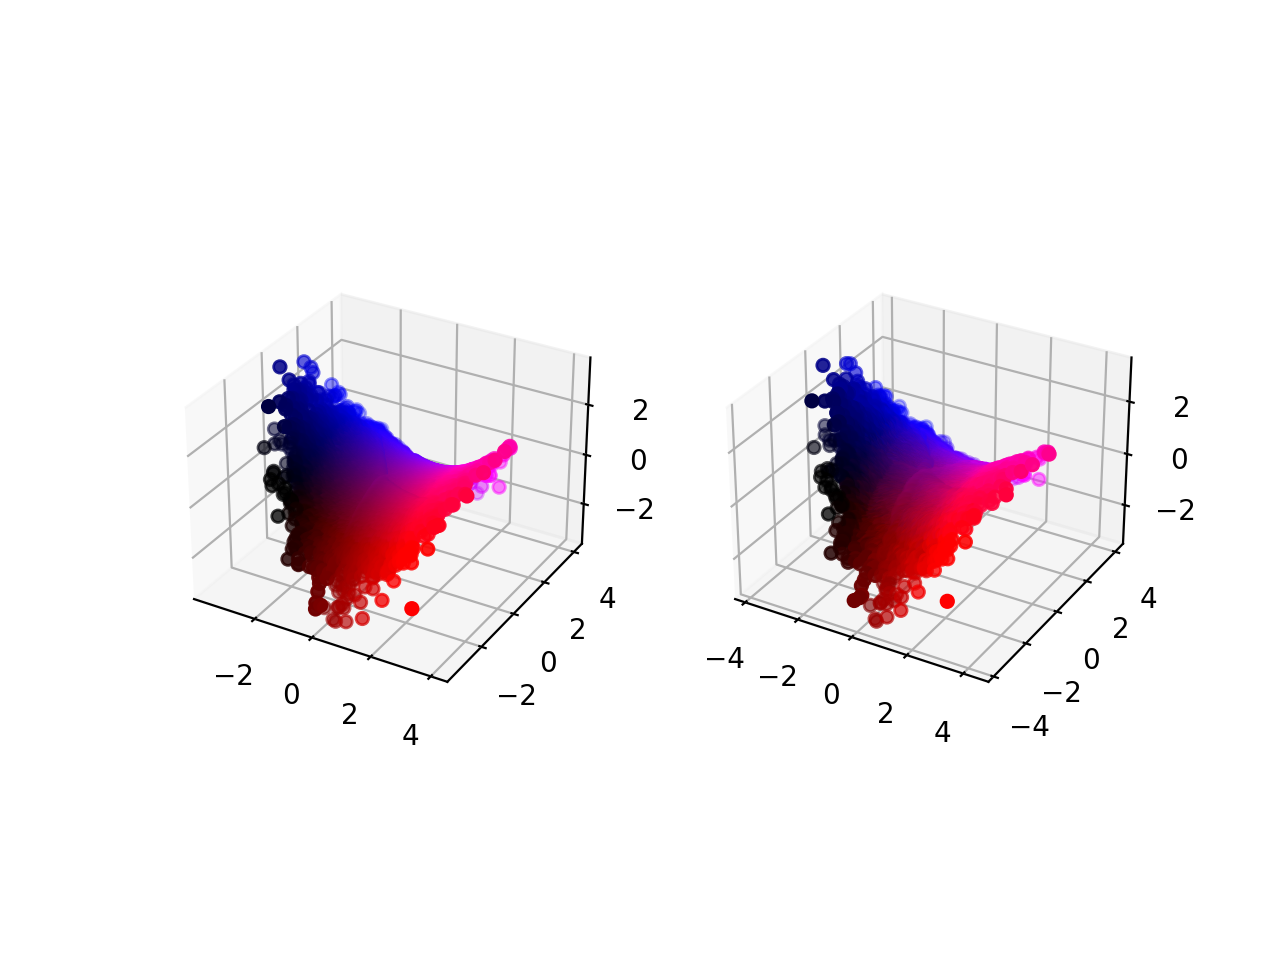

In [30]:
plt.figure()
a_true = plt.subplot(1,2,1, projection='3d')
a_fit = plt.subplot(1,2,2, projection='3d')

for i in range(n_individuals):
    
    intermediate_z_true = m_true(ind_data[i][0]).detach().numpy()
    intermediate_z_fit = ip_m_fit(ip_posteriors[i].latent_post.mns).detach().numpy()
    
    clrs = assign_colors_to_pts(ind_data[i][0], lims=np.asarray([[-2, 2], [-2, 2]]))
    
    fit_lm = ip_vi_collections[i].posteriors.lm_post(ind_props[i]).detach().squeeze()
    fit_mn = ip_vi_collections[i].posteriors.mn_post(ind_props[i]).detach().squeeze()
    fit_psi = ip_vi_collections[i].posteriors.psi_post.mode(ind_props[i]).detach().squeeze()
    fit_s = ip_vi_collections[i].posteriors.s_post(ind_props[i]).detach().squeeze()
    
    _, _, w, aligned_intermediate_z = align_intermediate_spaces(lm0=ind_true_mdls[i].lm.detach().numpy(), 
                                                                mn0=ind_true_mdls[i].mn.detach().numpy(),
                                                                s0=ind_true_mdls[i].s.detach().numpy(),
                                                                lm1=fit_lm.detach().numpy(), 
                                                                mn1=fit_mn.detach().numpy(),
                                                                s1=fit_s.detach().numpy(), 
                                                                int_z0=intermediate_z_true, 
                                                                int_z1=intermediate_z_fit, 
                                                                align_by_params=True)

    plot_three_dim_pts(intermediate_z_true, clrs=clrs, a=a_true)
    plot_three_dim_pts(aligned_intermediate_z, clrs=clrs, a=a_fit)

## View latents in low-d space

In [31]:
ind_data[0][0].shape

torch.Size([2534, 2])

<IPython.core.display.Javascript object>


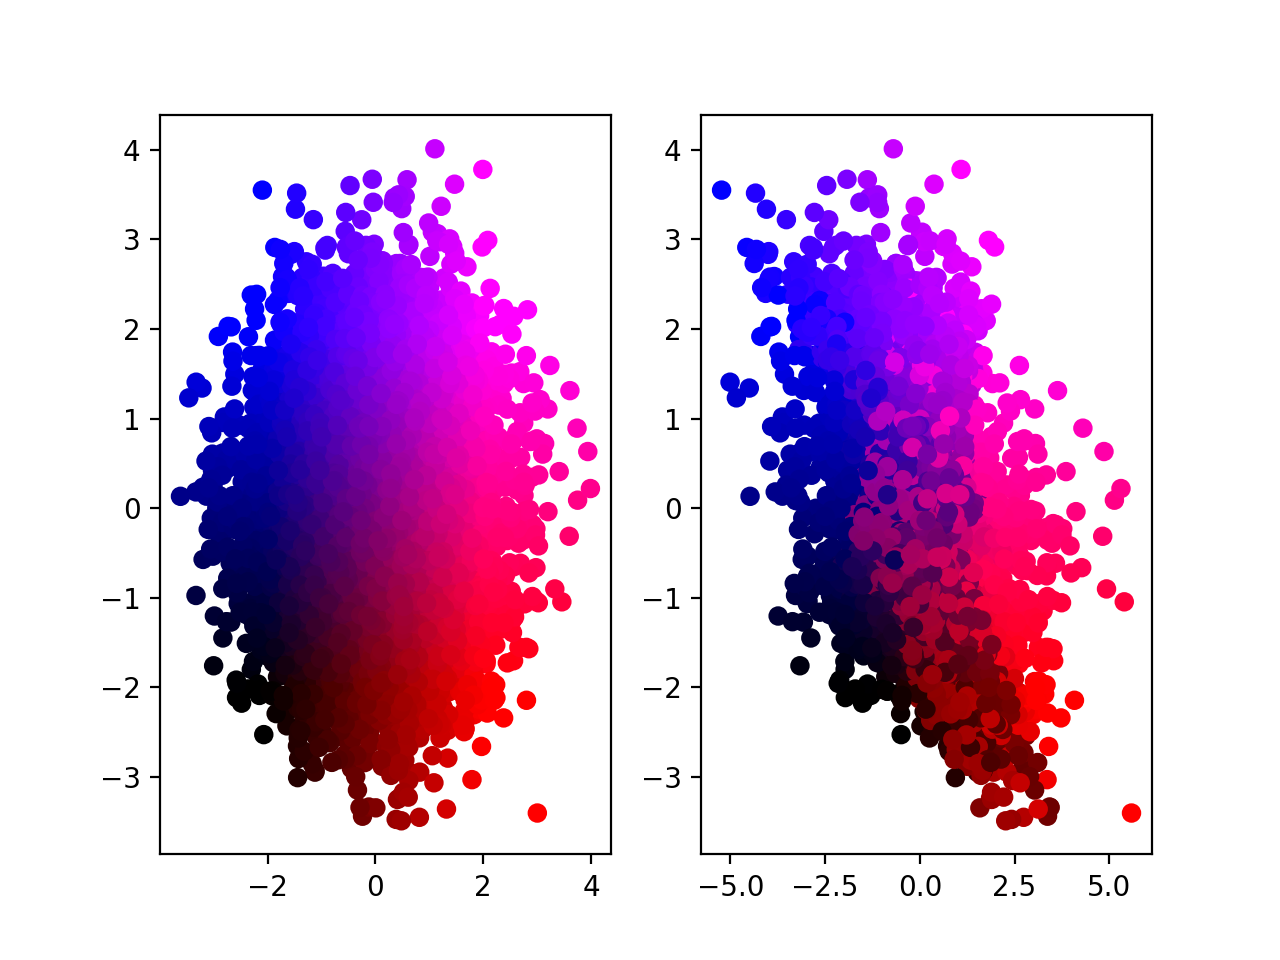

In [32]:
orig_z = np.concatenate([ind_data[i][0].numpy() for i in range(n_individuals)], axis=0)
fit_z = np.concatenate([ip_posteriors[i].latent_post.mns.detach().numpy() for i in range(n_individuals)], axis=0)
clrs = assign_colors_to_pts(orig_z, lims=np.asarray([[-2, 2], [-2, 2]]))

# Shuffle plotting order of points to avoid perceptual biases due to one color being 
# consistently plotted ontop of another
shuffled_inds = np.random.permutation(np.arange(orig_z.shape[0]))
orig_z = orig_z[shuffled_inds]
fit_z = fit_z[shuffled_inds]
clrs = clrs[shuffled_inds]

plt.figure()
a_true = plt.subplot(1, 2, 1)
a_fit = plt.subplot(1, 2, 2)
a_true.scatter(orig_z[:,0], orig_z[:,1], c=clrs)
a_fit.scatter(fit_z[:,0], orig_z[:,1], c=clrs)

## Examine true and fit distributions

<IPython.core.display.Javascript object>


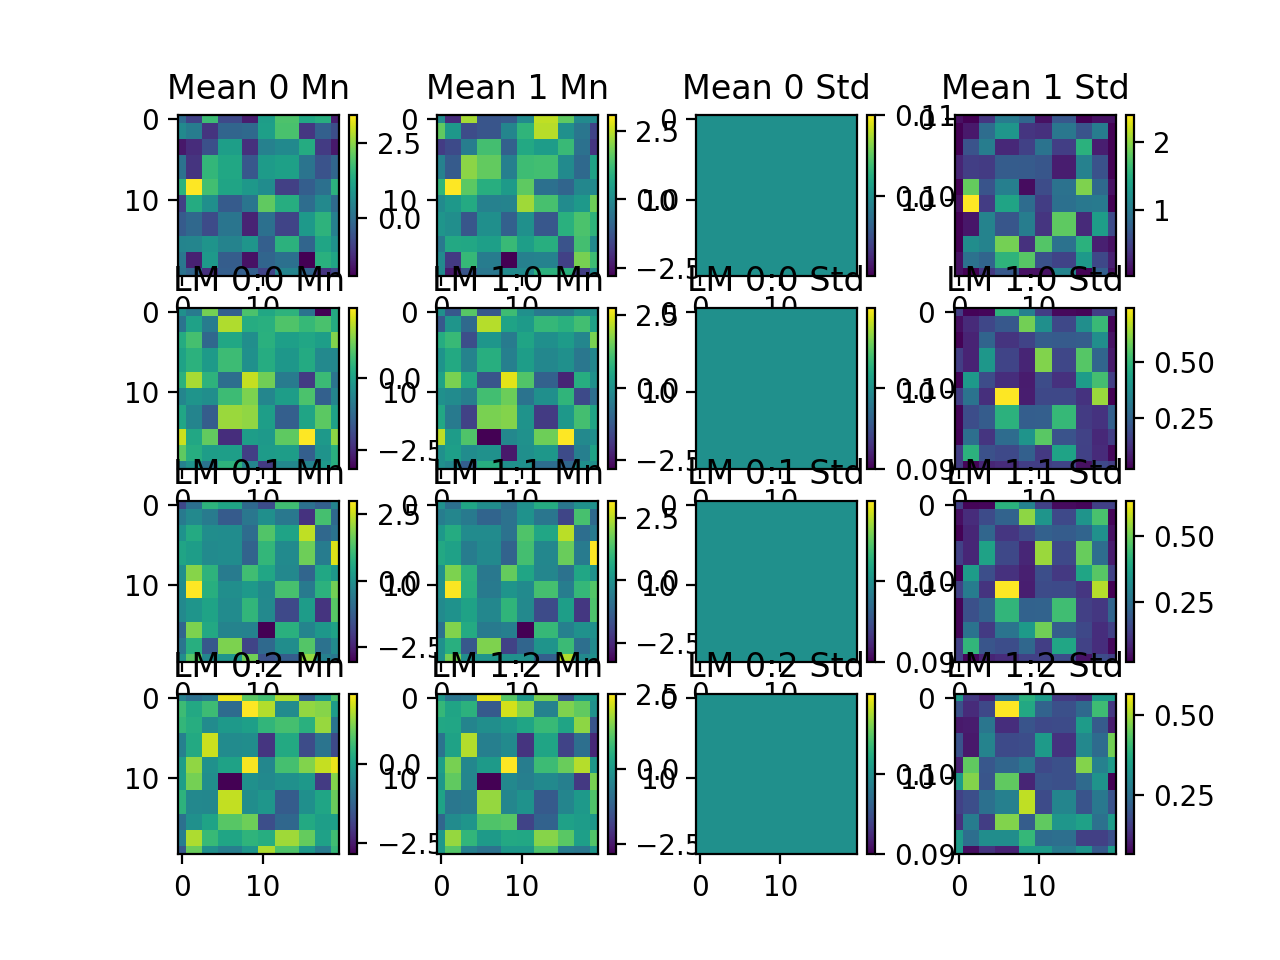

In [33]:
compare_mean_and_lm_dists(lm_0_prior=true_priors.lm_prior, mn_0_prior = true_priors.mn_prior,
                          s_0_prior = true_priors.s_prior, lm_1_prior = ip_priors.lm_prior,
                          mn_1_prior = ip_priors.mn_prior, s_1_prior = ip_priors.s_prior, 
                          dim_0_range=[0, 1], dim_1_range=[0, 1], n_pts_per_dim=[20, 20])

### Visualize parameters of the true prior distribution over private variances

<IPython.core.display.Javascript object>


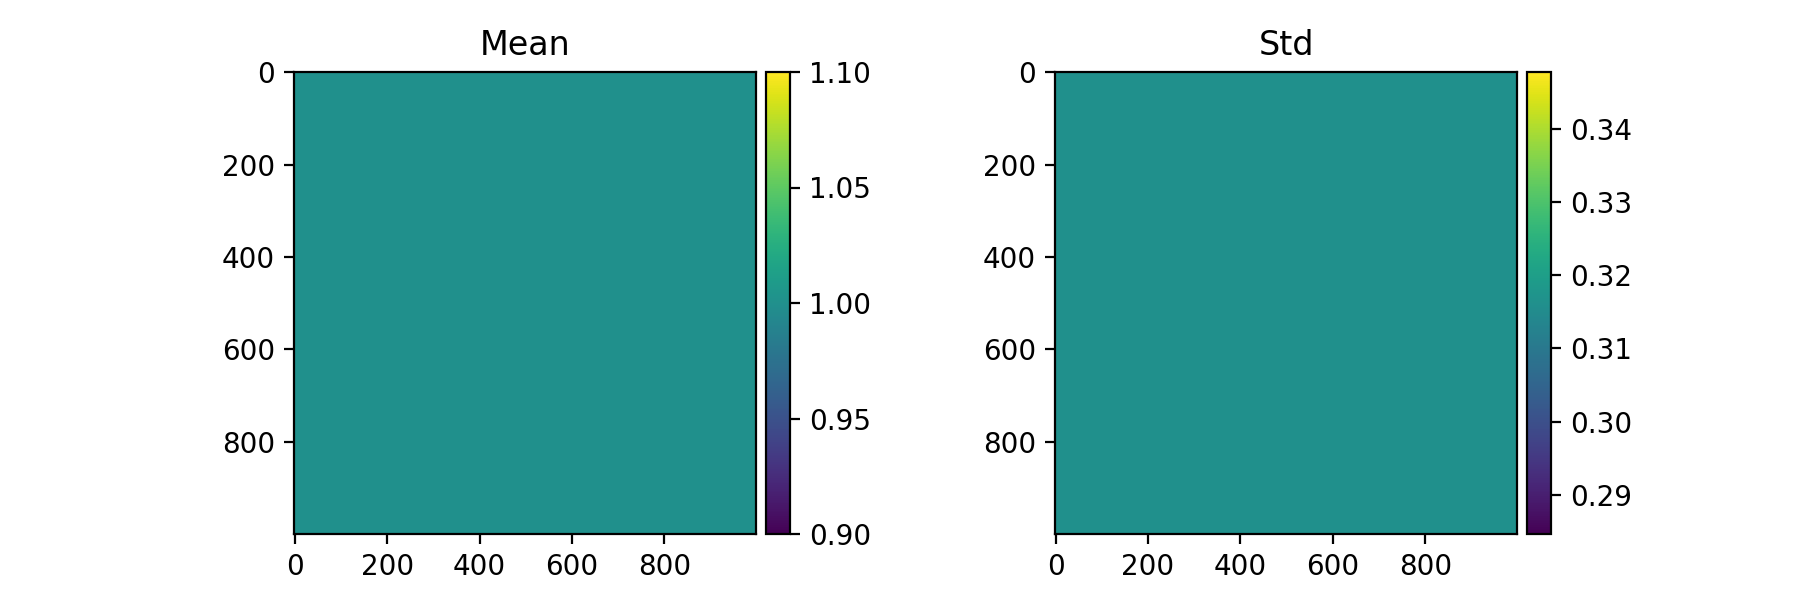

In [34]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=true_priors.psi_prior.forward, std_f=true_priors.psi_prior.std)

<IPython.core.display.Javascript object>


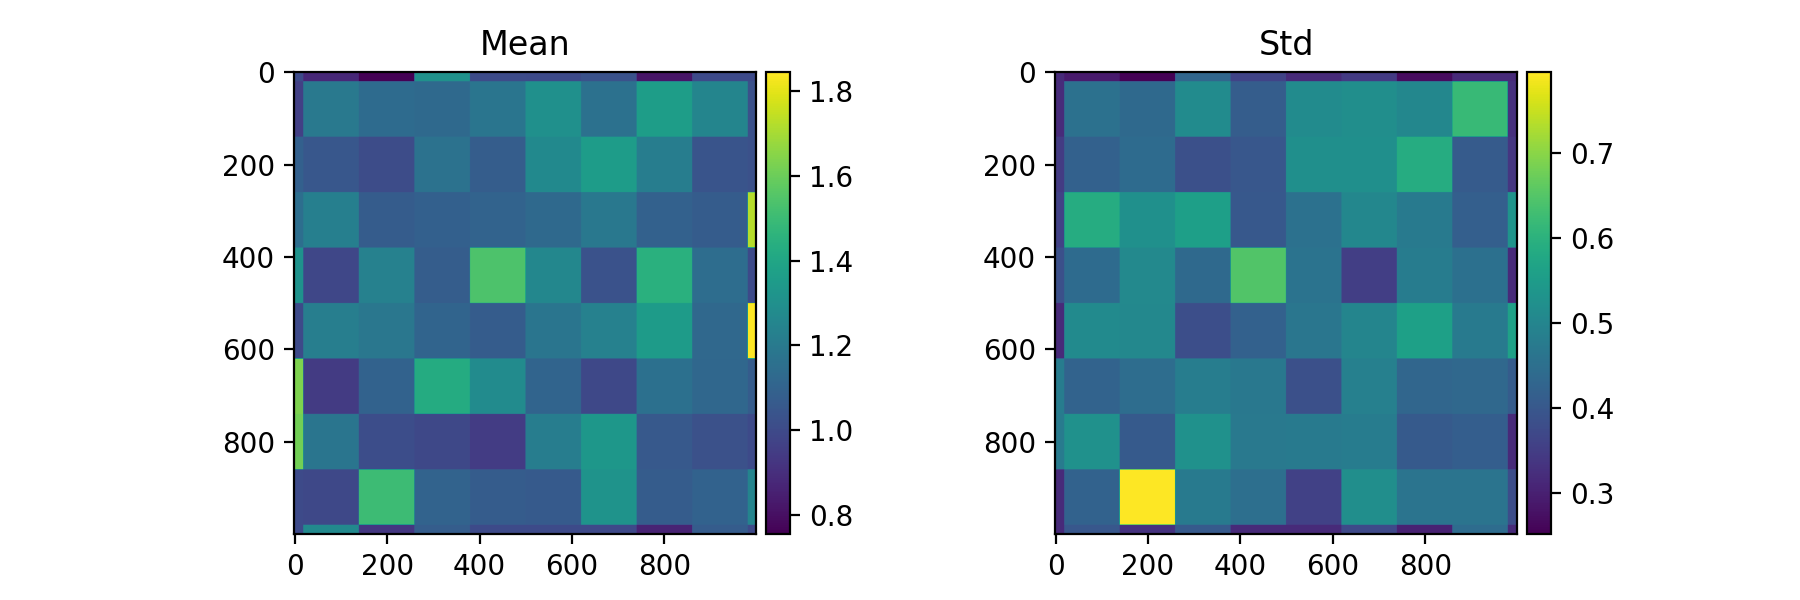

In [35]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=ip_priors.psi_prior.forward, std_f=ip_priors.psi_prior.std)

## Compare means conditioned on latents

<IPython.core.display.Javascript object>


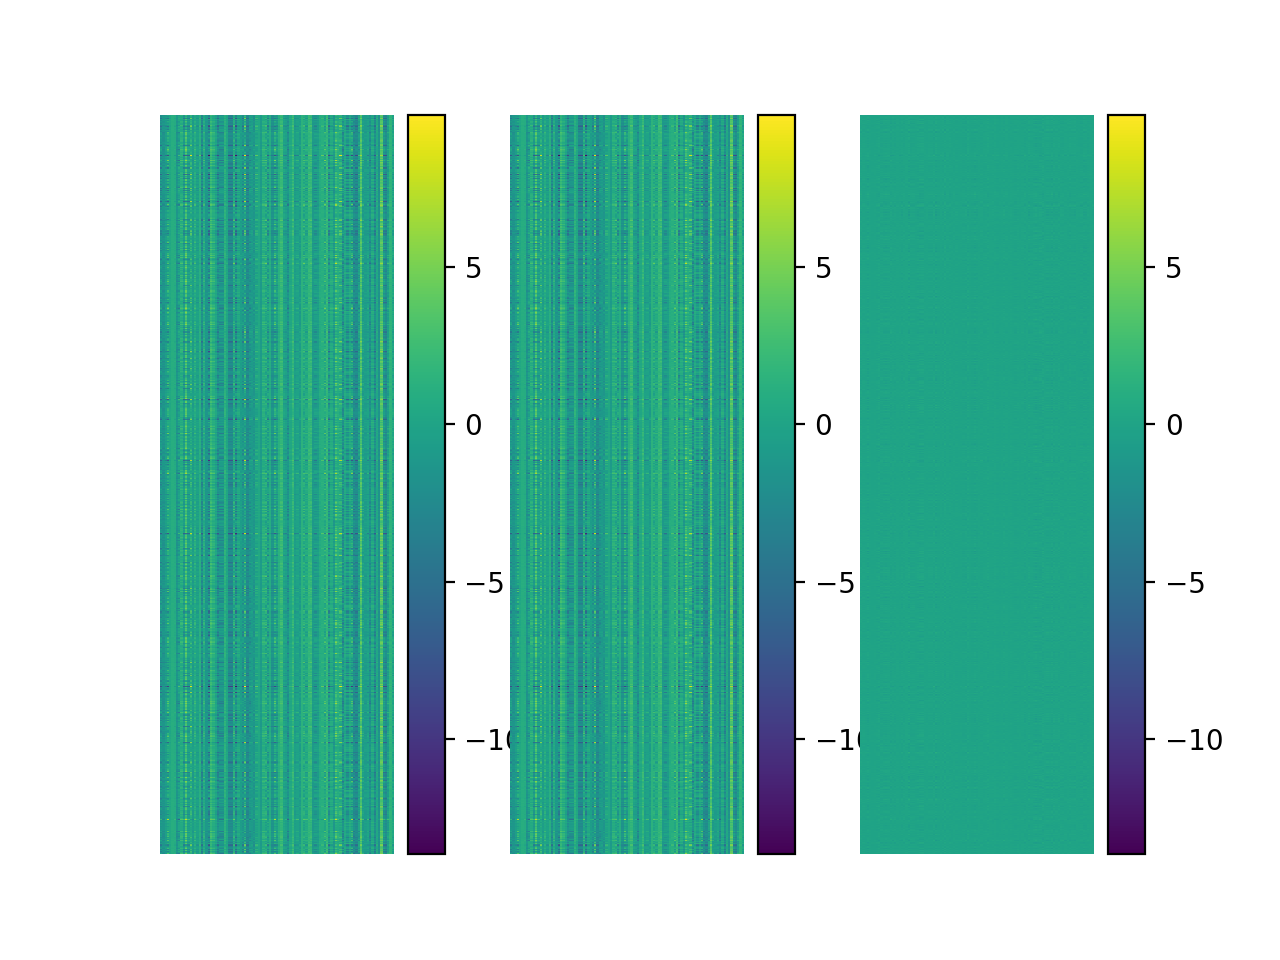

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

In [36]:
true_mns = ind_true_mdls[exam_mdl].cond_mean(ind_data[exam_mdl][0]).detach().numpy()

fit_lm = ip_vi_collections[exam_mdl].posteriors.lm_post(ind_props[exam_mdl]).detach().squeeze()
fit_mn = ip_vi_collections[exam_mdl].posteriors.mn_post(ind_props[exam_mdl]).detach().squeeze()
fit_psi = ip_vi_collections[exam_mdl].posteriors.psi_post.mode(ind_props[exam_mdl]).detach().squeeze()
fit_s = ip_vi_collections[exam_mdl].posteriors.s_post(ind_props[exam_mdl]).detach().squeeze()
    
fit_mns = ip_vi_collections[exam_mdl].mdl.cond_mean(z=ip_posteriors[exam_mdl].latent_post.mns, 
                                                    lm=fit_lm, 
                                                    mn=fit_mn, 
                                                    s=fit_s).detach().numpy()

plt.figure()
cmp_n_mats([true_mns, fit_mns, fit_mns-true_mns], show_colorbars=True)
#cmp_n_mats([ind_data[exam_mdl][1].numpy(), fit_mns, fit_mns-ind_data[exam_mdl][1].numpy()], show_colorbars=True)